**Name:** Alexia Ntantouri

**AEM:** 3871

In [ ]:
import numpy as np

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from sklearn.neural_network import MLPClassifier

from timeit import default_timer as timer

from keras.datasets import cifar10

import matplotlib.pyplot as plt

In [ ]:
# load the dataset
(X_train_not_norm, y_train), (X_test_not_norm, y_test) = cifar10.load_data()

# normalize the values
X_train, X_test = X_train_not_norm / 255.0, X_test_not_norm / 255.0

X_train_not_reshaped, X_test_not_reshaped = X_train, X_test

print("X_train dimensions: " + str(X_train.shape))
print("y_train dimensions: " + str(y_train.shape) + "\n")

print("X_test dimensions: " + str(X_test.shape))
print("y_test dimensions: " + str(y_test.shape))

170498071/170498071 [==============================] - 3s 0us/step
X_train dimensions: (50000, 32, 32, 3)
y_train dimensions: (50000, 1)

X_test dimensions: (10000, 32, 32, 3)
y_test dimensions: (10000, 1)


In [ ]:
# classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print("Classes: ", str(len(classes)), "\n")

for i in range(len(classes)):
  print(classes[i])

Classes:  10 

airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck


In [ ]:
# Convert to grayscale using the luminance formula (Y = 0.299*R + 0.587*G + 0.114*B)
X_train_gray = np.dot(X_train_not_norm, [0.299, 0.587, 0.114])

# Make sure the values are integers in the range [0, 255]
X_train_gray = X_train_gray.astype(np.uint8)

print(X_train_gray.shape)

# same for the test set
X_test_gray = np.dot(X_test_not_norm, [0.299, 0.587, 0.114])

# Make sure the values are integers in the range [0, 255]
X_test_gray = X_test_gray.astype(np.uint8)

print(X_test_gray.shape)


(50000, 32, 32)
(10000, 32, 32)


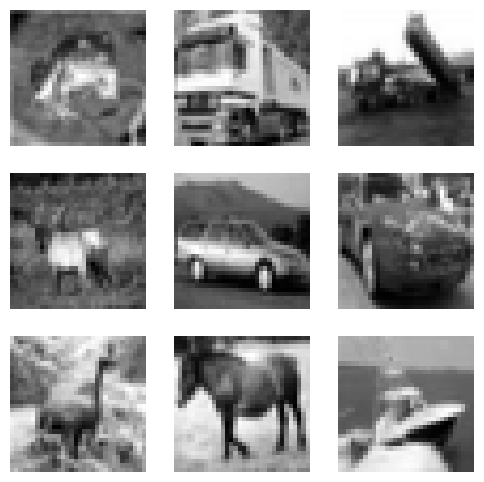

In [ ]:
# image samples

# Display the grayscale images
plt.figure(figsize=(6, 6))
for i in range(9):  # Display the first 25 images
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_train_gray[i], cmap='gray')
    plt.axis('off')

plt.show()

In [ ]:
# normalize the values
X_train_gray, X_test_gray = X_train_gray / 255.0, X_test_gray / 255.0

X_train_gray = np.reshape(X_train_gray, (X_train_gray.shape[0], -1))
X_test_gray = np.reshape(X_test_gray, (X_test_gray.shape[0], -1))

print("X_train_gray dimensions: " + str(X_train_gray.shape))
print("X_test_gray dimensions: " + str(X_test_gray.shape) + "\n")

X_train_gray dimensions: (50000, 1024)
X_test_gray dimensions: (10000, 1024)



In [ ]:
# reshape the data

# reshape the 4D array into a 2D array
# the first dimension (number of samples) should remain the same (50000)
# the -1 in the second dimension indicates that NumPy should automatically calculate
# the size of that dimension based on the total number of elements, maintaining the integrity of the data.
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

print("X_train dimensions: " + str(X_train.shape))
print("X_test dimensions: " + str(X_test.shape) + "\n")

X_train dimensions: (50000, 3072)
X_test dimensions: (10000, 3072)



# **MLP with grayscale images without PCA**

I converted the original images to grayscale to reduce the number of attributes by 1/3 (from **3072** to **1024**).

I set **early_stopping=True** to prevent overfitting.

**From sklearn:**

*Early stopping terminates training when validation score is not improving.*

*If set to true, it will automatically set aside 10% of training data as validation and terminate training when validation score is not improving by at least tol (default=1e-4) for n_iter_no_change (default=10) consecutive epochs. The split is stratified, except in a multilabel setting.*

*If early stopping is False, then the training stops when the training loss does not improve by more than tol for n_iter_no_change consecutive passes over the training set. Only effective when solver='sgd' or 'adam'.*

I managed to get **48% train accuracy** and **41% test accuracy** with 2 hidden layers (**100 neurons** in the first hidden layer and **50 neurons** in the second hidden layer).

The training took **206 seconds** and stopped after **60 iterations** (epochs).

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(100,50), max_iter=300, early_stopping=True)

start = timer()

mlp.fit(X_train_gray, y_train.ravel()) # ravel() will convert that array shape from (n,1) to (n, ) (i.e. flatten it)

end = timer()
print("Training time: ", end - start) # time in seconds

num_iterations = mlp.n_iter_
print("Number of iterations with early stopping:", num_iterations)

y_pred = mlp.predict(X_train_gray)
accuracy = accuracy_score(y_train, y_pred)
print("Train accuracy:", accuracy)

y_pred = mlp.predict(X_test_gray)
accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", accuracy)

Training time:  206.26613341900065
Number of iterations with early stopping: 60
Train accuracy: 0.48102
Test accuracy: 0.4148


# **MLP with grayscale images and PCA**

I used PCA to reduce the dimensionality of the dataset even more.

**Principal Component Analysis (PCA)** is a dimensionality reduction technique commonly used in machine learning. Its main goal is to transform a high-dimensional dataset into a new coordinate system, where the data variance is maximized along the new axes, called principal components. The idea is to capture the most important information in the data while discarding the less important aspects.

I used sklearn's PCA to hold **90%** of the variance of the data and the dimensionality of the dataset decreased from **1024** to **76** features (**-92.58%** decrease).

In [ ]:
from sklearn.decomposition import PCA

start = timer()

# PCA will hold 90% of the variance
pca = PCA(0.9)
pca.fit(X_train_gray)

end = timer()
print("Time: ", end - start) # time in seconds

# PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
#   svd_solver='auto', tol=0.0, whiten=False)

print(pca.n_components_)

Time:  11.925329054000002
76


In [ ]:
train_pca = pca.transform(X_train_gray)
test_pca = pca.transform(X_test_gray)

In [ ]:
print(train_pca.shape)
print(test_pca.shape)

print(y_train.shape)
print(y_test.shape)

(50000, 76)
(10000, 76)
(50000, 1)
(10000, 1)


The number of features contributes to the **computational complexity** of training a model. **More features** mean **more weights and parameters** that need to be learned during the training process.

Now, I can increase the number of neurons in the hidden layers because there are **less features** and so **less computations** are needed to train the MLP.

I managed to get **61% train accuracy** and **48% test accuracy** with 2 hidden layers (**400 neurons** in the first hidden layer and **100 neurons** in the second hidden layer).

The training took **90 seconds** and stopped after **22 iterations** (epochs).

In comparison to the MLP that was trained with the grayscale images but without PCA, we now managed to use **more neurons** in the hidden layers (from 100,50 to 400,100) with **less training time** (from 206 to 90 seconds) and **less number of iterations** (from 51 to 23).

That shows that PCA did a great job capturing the variance of the data!

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(400,100), max_iter=300, early_stopping=True) # early_stopping=True for validation scores

start = timer()

mlp.fit(train_pca, y_train.ravel()) # ravel() will convert that array shape from (n,1) to (n, ) (i.e. flatten it)

end = timer()
print("Training time: ", end - start) # time in seconds

num_iterations = mlp.n_iter_
print("Number of iterations with early stopping:", num_iterations)

y_pred = mlp.predict(train_pca)
accuracy = accuracy_score(y_train, y_pred)
print("Train accuracy:", accuracy)

y_pred = mlp.predict(test_pca)
accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", accuracy)

Training time:  25.747617274999996
Number of iterations with early stopping: 22
Train accuracy: 0.61012
Test accuracy: 0.4757


# **MLP with original images without PCA**

Now, I want to train an MLP with the original images (not grayscale).

As already mentioned, the number of features contributes to the **computational complexity** of training a model. **More features** mean **more weights and parameters** that need to be learned during the training process.

That means that **more computations** are needed to train the MLP since we have **more features** now (3072 and not 1024).

I used the same hyperparameters for the MLP that I used for the MLP trained with the grayscale images (**100 neurons** in the first hidden layer and **50 neurons** in the second hidden layer).

I got **53% train accuracy** and **49% test accuracy** which is better than the **48% train accuracy** and **41% test accuracy** from the MLP trained with the grayscale images.

The training took **241 seconds** and stopped after **40 iterations** (epochs) in comparison to the MLP with the grayscale images that took **206 seconds** and stopped after **60 iterations**.

So that means that using the original images for training is better than using the grayscale images since we get **better accuracy** and the training time is not much worse than the training time for the grayscale images.

The training with the original images stops after **40 iterations** in comparison to the **60 iterations** for the grayscale images which means that the model learns faster coloured images and struggles with grayscale ones.

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(100,50), max_iter=300, early_stopping=True)

start = timer()

mlp.fit(X_train, y_train.ravel()) # ravel() will convert that array shape from (n,1) to (n, ) (i.e. flatten it)

end = timer()
print("Training time: ", end - start) # time in seconds

num_iterations = mlp.n_iter_
print("Number of iterations with early stopping:", num_iterations)

y_pred = mlp.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
print("Train accuracy:", accuracy)

y_pred = mlp.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", accuracy, "\n")

Training time:  241.58664833500006
Number of iterations with early stopping: 40
Train accuracy: 0.5294
Test accuracy: 0.485 



# **MLP with original images and PCA**
We concluded that coloured images are better than grayscale ones for training our MLP.

Now, I am going to use PCA to reduce the dimensionality of the dataset, because we saw from applying PCA to the grayscale images, that PCA was really effective in capturing the variance of the data.

Remember, that with PCA we were able to use a **more complex MLP** with **more neurons** in the hidden layers and still have **less training time** and **less number of iterations**.

I used sklearn's PCA to hold **90%** of the variance of the data and the dimensionality of the dataset decreased from **3072** to **99** features (**-96.78%** decrease).

In [ ]:
from sklearn.decomposition import PCA

start = timer()

# PCA will hold 90% of the variance
pca = PCA(0.9)
pca.fit(X_train)

end = timer()
print("Time: ", end - start) # time in seconds

# PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
#   svd_solver='auto', tol=0.0, whiten=False)

print(pca.n_components_)

Time:  99.354720898
99


In [ ]:
train_pca = pca.transform(X_train)
test_pca = pca.transform(X_test)

In [ ]:
print(train_pca.shape)
print(test_pca.shape)

print(y_train.shape)
print(y_test.shape)

(50000, 99)
(10000, 99)
(50000, 1)
(10000, 1)


I used the same hyperparameters for the MLP that I used for the MLP trained with the grayscale images and PCA (**400 neurons** in the first hidden layer and **100 neurons** in the second hidden layer).

I got **67% train accuracy** and **54% test accuracy** which is better than the **61% train accuracy** and **48% test accuracy** from the MLP trained with the grayscale images and PCA.

Remember also, that training with the original images without PCA, gave us **53% train accuracy** and **49% test accuracy** and the training took **241 seconds** and stopped after **40 iterations** (epochs).

The training, now, took **79 seconds** and stopped after **18 iterations** (epochs) in comparison to the MLP with the grayscale images and PCA that took **26 seconds** and stopped after **22 iterations**.

So, that confirms that **coloured images** are better than **grayscale images** for training the MLP and **PCA** is great for reducing the dimensionality of the data making the training faster and increasing the accuracy of the model.

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(400,100), max_iter=300, early_stopping=True) # early_stopping=True for validation scores

start = timer()

mlp.fit(train_pca, y_train.ravel()) # ravel() will convert that array shape from (n,1) to (n, ) (i.e. flatten it)

end = timer()
print("Time: ", end - start) # time in seconds

num_iterations = mlp.n_iter_
print("Number of iterations with early stopping:", num_iterations)

y_pred = mlp.predict(train_pca)
accuracy = accuracy_score(y_train, y_pred)
print("Train accuracy:", accuracy)

y_pred = mlp.predict(test_pca)
accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", accuracy)

Time:  79.22532850800053
Number of iterations with early stopping: 18
Train accuracy: 0.67362
Test accuracy: 0.541


# **Randomized Search**
So, we concluded that the best way to train the MLP is by using the **coloured images** and also **PCA**.

This way, we managed to get **67% train accuracy** and **54% test accuracy**.

But can we make our model even more accurate?

I used sklearn's RandomizedSearchCV to find the best hyperparameters for the model.

**From sklearn:**

*In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is given by n_iter.*

RandomizedSearchCV gave us a model that achieves **73% train accuracy** and **56% test accuracy**.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

mlp = MLPClassifier(max_iter=300, early_stopping=True)

parameter_grid = {
    'hidden_layer_sizes': [(400,100), (500), (600,200)],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant','adaptive'],
}

grid_search = RandomizedSearchCV(mlp, parameter_grid, random_state=2, n_iter=5, cv=5, n_jobs=-1)

start = timer()

grid_search.fit(train_pca, y_train.ravel())

end = timer()
print("Time: ", end - start) # time in seconds

print("Best params:")
print(grid_search.best_params_)

Time:  2740.676056788001
Best params:
{'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (600, 200), 'alpha': 0.001, 'activation': 'relu'}


In [ ]:
# perform the prediction to the train set
y_pred = grid_search.predict(train_pca)

accuracy = accuracy_score(y_train, y_pred)
print("Train accuracy:", accuracy, "\n")


# perform the prediction to the test set
y_pred = grid_search.predict(test_pca)

accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", accuracy, "\n")

Train accuracy: 0.73334 

Test accuracy: 0.5558 



# **Experimenting with different numbers of neurons**

After RandomizedSearchCV, I also experimented with different numbers of hidden layers and different numbers of neurons in each layer.

In [ ]:
def print_results(mlp):
  start = timer()

  mlp.fit(train_pca, y_train.ravel()) # ravel() will convert that array shape from (n,1) to (n, ) (i.e. flatten it)

  y_pred = mlp.predict(test_pca)

  end = timer()
  print("Time: ", end - start) # time in seconds

  num_iterations = mlp.n_iter_
  print("Number of iterations with early stopping:", num_iterations)

  y_pred = mlp.predict(train_pca)
  accuracy = accuracy_score(y_train, y_pred)
  print("Train accuracy:", accuracy)


  y_pred = mlp.predict(test_pca)
  accuracy = accuracy_score(y_test, y_pred)
  print("Test accuracy:", accuracy, "\n")


mlp1 = MLPClassifier(hidden_layer_sizes=(500,), # --changed from (200,) to (500,)--
                    alpha=0.001,                # --changed from 0.0001 to 0.001--
                    learning_rate='adaptive',   # --changed from constant to adaptive--
                    early_stopping=True,)

print_results(mlp1)

mlp2 = MLPClassifier(hidden_layer_sizes=(500,100),  # --changed from (200,) to (500,100)--
                    alpha=0.001,                    # --changed from 0.0001 to 0.001--
                    learning_rate='adaptive',       # --changed from constant to adaptive--
                    early_stopping=True,)

print_results(mlp2)

mlp3 = MLPClassifier(hidden_layer_sizes=(500,400,100),  # --changed from (200,) to (500,400,100)--
                    alpha=0.001,                        # --changed from 0.0001 to 0.001--
                    learning_rate='adaptive',           # --changed from constant to adaptive--
                    early_stopping=True,)

print_results(mlp3)

Time:  36.04461701800028
Number of iterations with early stopping: 20
Train accuracy: 0.66982
Test accuracy: 0.5522 

Time:  57.51817001100062
Number of iterations with early stopping: 20
Train accuracy: 0.72496
Test accuracy: 0.5518 

Time:  135.4871001620013
Number of iterations with early stopping: 17
Train accuracy: 0.72816
Test accuracy: 0.5493 



# **The MLP I chose**

The best accuracy that I managed to get was **77% for the training set** and **56% for the test set**.

To get this accuracy I used the **original images** (not grayscale) and I used **PCA** to reduce the dimensionality of the dataset.

To be find the best parameters I used sklearn's RandomizedSearchCV and I also tried changing hyperparameters manually and see how changing one hyperparameter changed the accuracy.

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(600,200), # --changed from (200,) to (600,200)--
                    activation='relu',
                    solver='adam',
                    alpha=0.001,              # --changed from 0.0001 to 0.001--
                    batch_size='auto',
                    learning_rate='adaptive', # --changed from constant to adaptive--
                    learning_rate_init=0.001, # Only used when solver='sgd' or 'adam'
                    power_t=0.5,              # Only used when solver='sgd'
                    max_iter=200,
                    shuffle=True,             # Only used when solver='sgd' or 'adam'
                    random_state=None,
                    tol=0.0001,
                    verbose=False,
                    warm_start=False,
                    momentum=0.9,             # Only used when solver='sgd'
                    nesterovs_momentum=True,  # Only used when solver='sgd' and momentum > 0
                    early_stopping=True,      # --changed from False to True-- # Only effective when solver='sgd' or 'adam'
                    validation_fraction=0.1,  # Only used if early_stopping is True
                    beta_1=0.9,               # Only used when solver='adam'
                    beta_2=0.999,             # Only used when solver='adam'
                    epsilon=1e-08,            # Only used when solver='adam'
                    n_iter_no_change=10,      # Only effective when solver='sgd' or 'adam'
                    max_fun=15000)            # Only used when solver='lbfgs'

start = timer()

mlp.fit(train_pca, y_train.ravel()) # ravel() will convert that array shape from (n,1) to (n, ) (i.e. flatten it)

y_pred = mlp.predict(test_pca)

end = timer()
print("Time: ", end - start) # time in seconds

num_iterations = mlp.n_iter_
print("Number of iterations with early stopping:", num_iterations)

y_pred = mlp.predict(train_pca)
accuracy = accuracy_score(y_train, y_pred)
print("Train accuracy:", accuracy)

y_pred = mlp.predict(test_pca)
accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", accuracy)

Time:  52.91149928399997
Number of iterations with early stopping: 20
Train accuracy: 0.77094
Test accuracy: 0.5603


By definition, a confusion matrix C is such that Ci,j  is equal to the number of observations known to be in group i and predicted to be in group j.
.

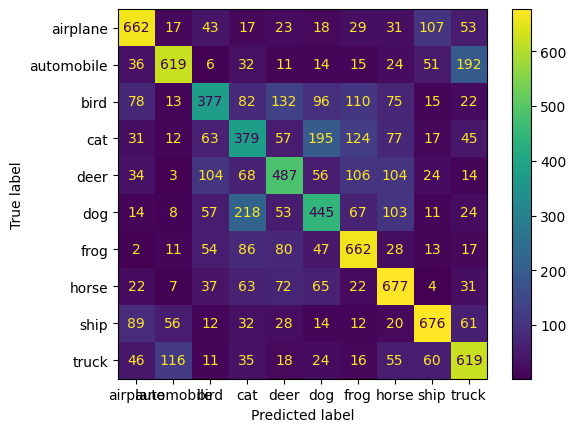

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()

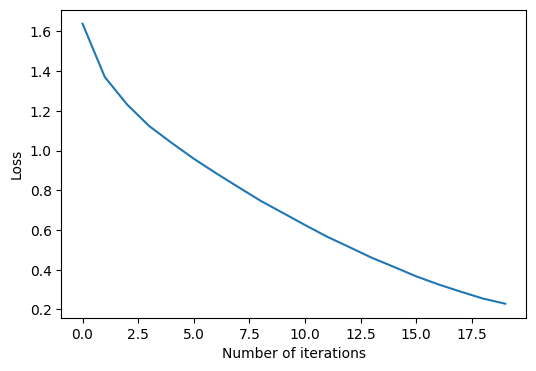

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(mlp.loss_curve_)
ax.set_xlabel('Number of iterations')
ax.set_ylabel('Loss')
plt.show()

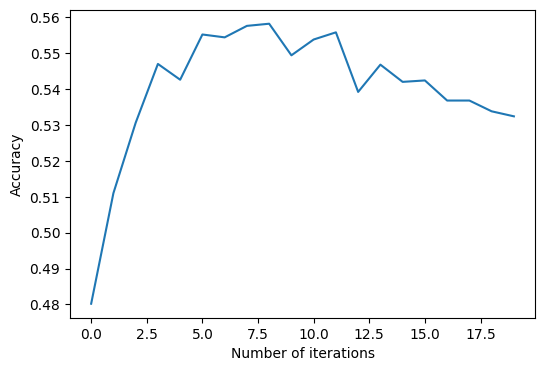

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(mlp.validation_scores_)
ax.set_xlabel('Number of iterations')
ax.set_ylabel('Accuracy')
plt.show()

# **Examples of correctly and wrongly classified images**

For the number  1  sample:
The correct class was:  cat  and it was correctly classified as:  cat


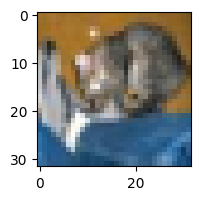

In [ ]:
for i in range(len(y_pred)):
  if y_pred[i]==y_test[i][0]:
    print("For the number ", i+1, " sample:")
    print("The correct class was: ", classes[y_test[i][0]], " and it was correctly classified as: ", classes[y_pred[i]])
    break

plt.figure(figsize=(2, 2))
plt.imshow(X_test_not_reshaped[i], cmap=plt.get_cmap('CMRmap'))
plt.show()

For the number  2  sample:
The correct class was:  ship  and it was wrongly classified as:  automobile


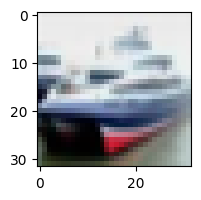

In [ ]:
for i in range(len(y_pred)):
  if y_pred[i]!=y_test[i][0]:
    print("For the number ", i+1, " sample:")
    print("The correct class was: ", classes[y_test[i][0]], " and it was wrongly classified as: ", classes[y_pred[i]])
    break

plt.figure(figsize=(2, 2))
plt.imshow(X_test_not_reshaped[i], cmap=plt.get_cmap('CMRmap'))
plt.show()

# **Convolutional network with Keras**

I also trained a convolutional neural network using Keras, since Convolutional Neural Networks (CNNs) are widely considered to be highly effective for image classification tasks. The architecture of CNNs is designed to handle grid-like data structures, such as images, by leveraging convolutional layers to automatically learn hierarchical representations of features.

Indeed the CNN managed to get **84% train accuracy** and **72% test accuracy**, in comparison to the **76% train accuracy** and **55% test accuracy** from the fully connected neural network.

I didn't do many experiments with CNN's but I easily got a better accuracy in comparison to the fully connected neural network, which goes to show that CNN's are better than fully connected neural networks for image classification problems.

In [ ]:
from keras import layers, models
from keras.datasets import cifar10
from keras.utils import to_categorical

# Load CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# One-hot encode the labels
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

# Build the CNN model
model = models.Sequential()

# Convolutional and pooling layers
# Adding a convolutional layer with 32 filters/kernels of 3x3 size each (each filter is a 3x3 grid)
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
# After applying a convolutional layer, MaxPooling2D is used with a 2x2 window,
# reducing the spatial dimensions by half.
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# This defines the feature detector part of the model. This must be coupled with a classifier
# part of the model that interprets the features and makes a prediction as to which class a given image belongs.

# This can be fixed for each model that we investigate. First, the feature maps output from
# the feature extraction part of the model must be flattened. We can then interpret them with one
# or more fully connected layers, and then output a prediction. The output layer must have 10 nodes
# for the 10 classes and use the softmax activation function.

# Fully connected layers
model.add(layers.Flatten()) # flatten layer to convert the 3D output to 1D.
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))  # 10 classes for CIFAR-10

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# check model architecture
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 4, 4, 64)          36928     
                                                                 
 flatten_4 (Flatten)         (None, 1024)             

In [ ]:
# Train the model
history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 [==============================] - 76s 48ms/step - loss: 1.5168 - accuracy: 0.4478 - val_loss: 1.2344 - val_accuracy: 0.5532
Epoch 2/10
1563/1563 [==============================] - 75s 48ms/step - loss: 1.1522 - accuracy: 0.5900 - val_loss: 1.0648 - val_accuracy: 0.6186
Epoch 3/10
1563/1563 [==============================] - 74s 47ms/step - loss: 0.9870 - accuracy: 0.6532 - val_loss: 1.0062 - val_accuracy: 0.6397
Epoch 4/10
1563/1563 [==============================] - 77s 49ms/step - loss: 0.8872 - accuracy: 0.6886 - val_loss: 0.9407 - val_accuracy: 0.6672
Epoch 5/10
1563/1563 [==============================] - 75s 48ms/step - loss: 0.8059 - accuracy: 0.7166 - val_loss: 0.9164 - val_accuracy: 0.6765
Epoch 6/10
1563/1563 [==============================] - 74s 47ms/step - loss: 0.7484 - accuracy: 0.7370 - val_loss: 0.8506 - val_accuracy: 0.7064
Epoch 7/10
1563/1563 [==============================] - 74s 48ms/step - loss: 0.6941 - accuracy: 0.7553 - val_loss: 0.8538 -

In [ ]:
# Evaluate the model on the train set
train_loss, train_acc = model.evaluate(train_images, train_labels)
print("Train accuracy :", train_acc)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_images, test_labels)
print("Test accuracy :", test_acc)

1563/1563 [==============================] - 22s 14ms/step - loss: 0.4598 - accuracy: 0.8402
Train accuracy : 0.8401600122451782
313/313 [==============================] - 6s 19ms/step - loss: 0.8501 - accuracy: 0.7190
Test accuracy : 0.718999981880188


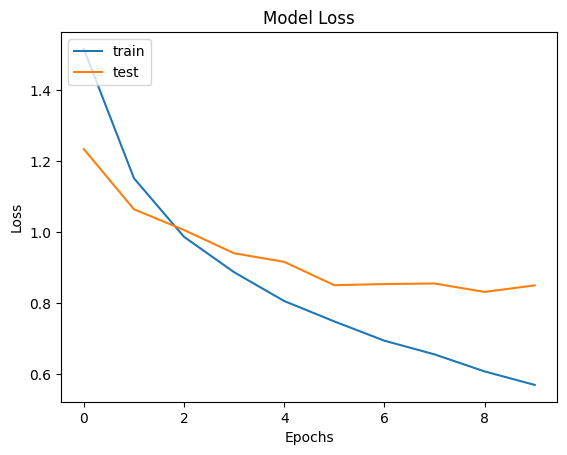

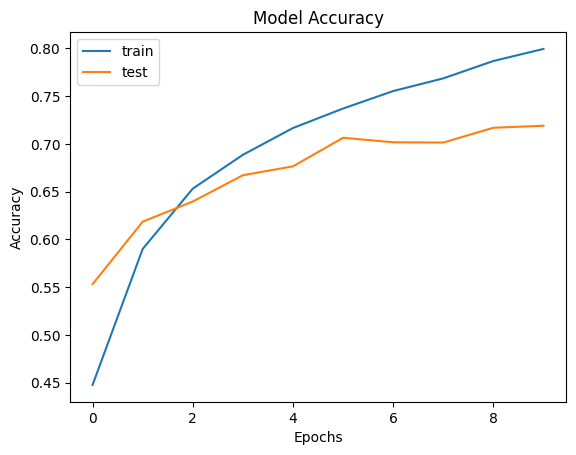

In [ ]:
# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Resources

https://scikit-learn.org/stable/

https://www.datacamp.com/tutorial/principal-component-analysis-in-python

https://www.kaggle.com/code/minhbtnguyen/multi-layer-perceptron-on-cifar10-visualization

https://wandb.ai/mostafaibrahim17/ml-articles/reports/A-Deep-Dive-Into-Learning-Curves-in-Machine-Learning--Vmlldzo0NjA1ODY0

https://www.youtube.com/watch?v=pj9-rr1wDhM

https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/